<p align="left">
  <img src="./logo_UTN.svg" />
</p>


# **Teoría de Circuitos II - R4001 - 2023**
## Trabajo Semanal 8
### Autor: Bruno Glecer

# Consignas

# Parte 1

## Diseño IIR

### Inicialización y parametros del filtro

In [1]:
import warnings
warnings.filterwarnings('ignore')
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

#Parametros del filtro
fs = 1000
fny = fs / 2

ripple = 0 # dB
atenuacion = 40 # dB

fs1 = 1.0 #Hz
fp1 = 3.0 #Hz
fp2 = 25.0 #Hz
fs2 = 35.0 #Hz

# Frecuencias digitales y ganancias para dibujar plantilla
frecs = np.array([0.0,         fs1,         fp1,     fp2,     fs2,         fny   ]) / fny 
gains_db = 10**(np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])/20)


### Diseño filtro IIR

Para diseñar un filtro IIR de forma sencilla, utilizo la funcion iirdesign. Decidí utilizar un filtro Butterworth. Debido a que el orden del filtro producido es alto (alrededor de 30), implementarlo como un solo filtro causaria inestabilidad numerica, por eso es necesario exportarlo y implementarlo como una serie de filtros de orden chico, en ese caso como se exporta en formato SOS, la salida representara una serie de filtros de orden 2.

Debido a que iirdesign no admite un parametro de ripple cero, utilizo 0.5 como valor de ripple.

Utilizando sosfreqz puedo muestrear la respuesta del filtro para el intervalo de frecuencias entre 0Hz y su frecuencia de Nyquist de 500Hz.

In [2]:
iir_sos = sig.iirdesign([fp1, fp2], [fs1, fs2], 0.5, atenuacion, ftype='butter', fs=fs, output='sos', analog=False)

iir_W, iir_H = sig.sosfreqz(iir_sos, fs=fs, worN=10000)

### Diseño filtro FIR

Para el diseño del filtro FIR decido utilizar el metodo iterativo de cuadrados minimos. Debido a ser un metodo por arpoximaciones sucesivas, este no garantiza un filtro que cumpla exactamente con la plantilla. Un desperfecto caracteristico de este metodo es la aparición de oscilaciones cuando se cambia de banda. Por observación, decidi agregar 2dB más de atenuacion en la banda de corte, para evitar que este ripple no se superponga con la plantilla.
El parametro de 5001 muestras, fue elegido por prueba y error haste encontrar un valor que se comporte bien sin que sea demasiado exigente computacionalmente

In [3]:
extra_stop_att = 2

bands = [[0, fs1] , [fs1, fp1], [fp1, fp2], [fp2, fs2], [fs2, fs/2]]
gains_db = [[-atenuacion - extra_stop_att, -atenuacion - extra_stop_att],
            [-atenuacion, 0], [0, 0], [0, -atenuacion],
            [-atenuacion - extra_stop_att, -atenuacion - extra_stop_att]]
gains = 10**(np.array(gains_db)/20)

taps_ls = sig.firls(5001, bands, gains, fs=fs)

fir_W, fir_H = sig.freqz(taps_ls, [1], worN=10000, fs=fs)


### Respuestas de modulo

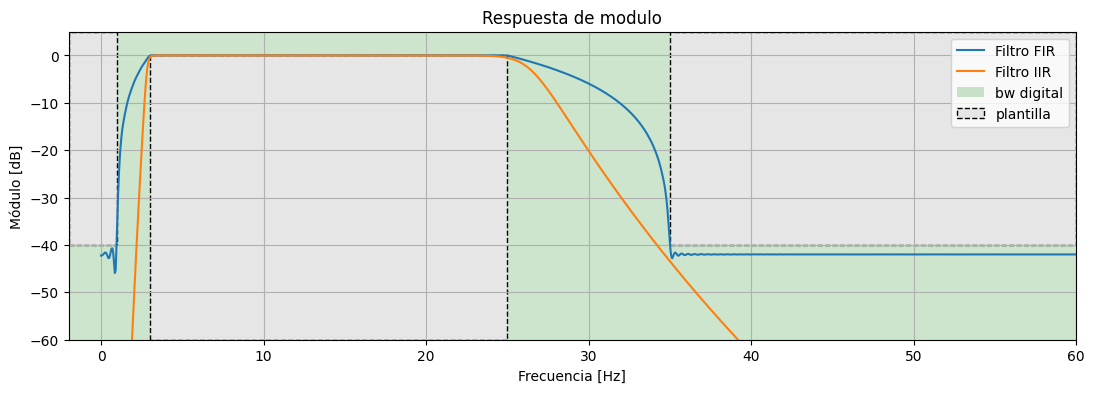

In [4]:
mpl.rcParams['figure.figsize'] = (13,4)

plt.plot(fir_W, 20*np.log10(np.abs(fir_H)), label="Filtro FIR")
plt.plot(iir_W, 20*np.log10(np.abs(iir_H)), label="Filtro IIR")

plt.title('Respuesta de modulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([-2, 60, -60, 5 ]);
plot_plantilla(filter_type = 'bandpass', fpass=[fp1, fp2], fstop=[fs1, fs2], ripple=ripple, attenuation=atenuacion, fs = fs)



La respuesta de modulo muestra como cada filtro se compara con la plantilla. A simple inspección el filtro IIR parece tener mejores características, este no tiene ninguna superposición con la plantilla. El filtro IIR también tiene mayor roll-off que el FIR.

### Respuesta de fase FIR

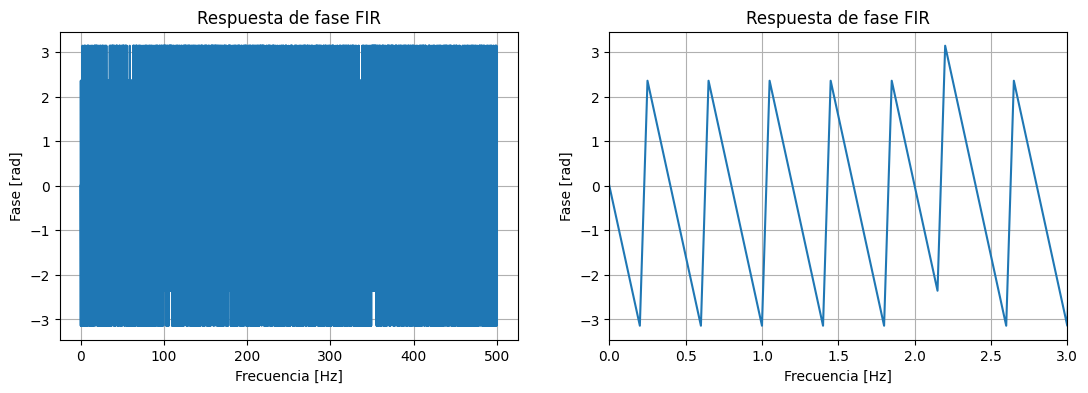

In [5]:
fig, ax = plt.subplots(1,2)

ax[0].plot(fir_W, np.angle(fir_H))
ax[0].set_title('Respuesta de fase FIR')
ax[0].set_xlabel('Frecuencia [Hz]')
ax[0].set_ylabel('Fase [rad]')
ax[0].grid()

ax[1].plot(fir_W, np.angle(fir_H))
ax[1].set_title('Respuesta de fase FIR')
ax[1].set_xlabel('Frecuencia [Hz]')
ax[1].set_ylabel('Fase [rad]')
ax[1].set_xlim(0,3)
ax[1].grid()

plt.show()

Arriba se muestra la respuesta de fase del filtro FIR. Como es el caso en todos los filtros de este tipo, su fase es perfectamente lineal. Pero debido a su orden alto, la fase tiene una pendiente muy alta, y al estar graficandola como un valor entre $-\pi$ y $\pi$, el grafico de la fase completo no llega a mostrar detalle. A la derecha se encuentra una versión acotada del mismo grafico en donde se ve que la fase decrece linealmente.

Para visualizar mejor la fase, en este caso lo mejor es mostrarla tomando en cuenta las rotaciónes que dió. A continuacion se muestra la respuesta del filtro FIR completa, en donde se puede ver su linealidad.

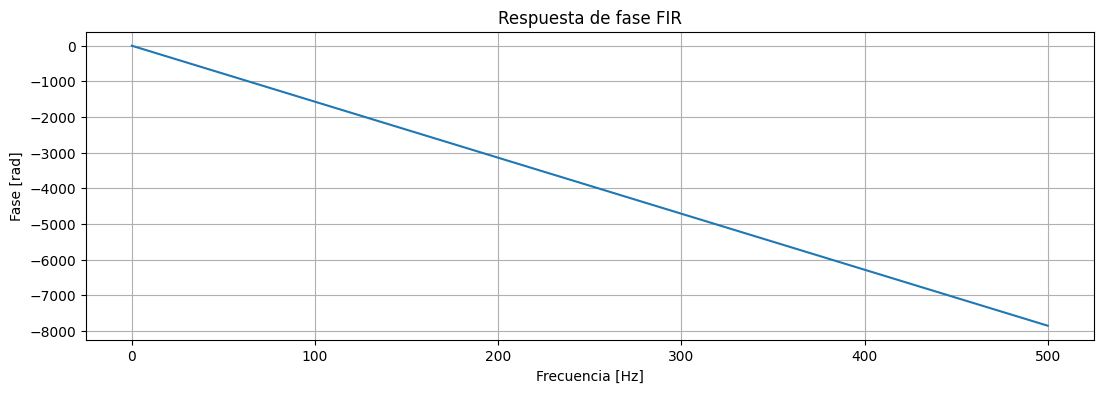

In [6]:
def angle_to_winding_number(angles):
    diff_angles = np.diff(angles)
    winding_changes = np.where(diff_angles > np.pi, -2*np.pi, 0) + np.where(diff_angles < -np.pi, 2*np.pi, 0)
    winding_numbers = np.append([0], np.cumsum(winding_changes))
    return winding_numbers + angles

fig, ax = plt.subplots()

ax.plot(fir_W, angle_to_winding_number(np.angle(fir_H)))
ax.set_title('Respuesta de fase FIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()


plt.show()

### Respuesta de IIR

Como era de esperar, la fase del filtro IIR no obedece un comporamiento especial.

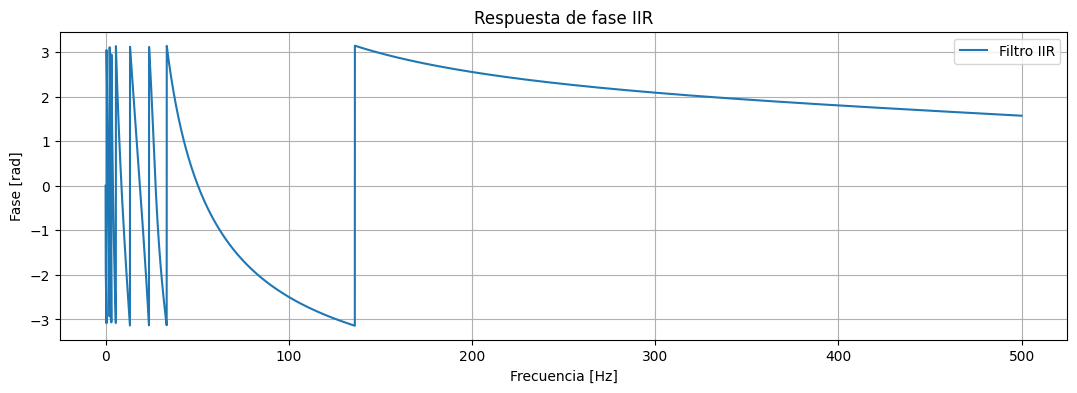

In [7]:
fig, ax = plt.subplots()

ax.plot(iir_W, (np.angle(iir_H)), label="Filtro IIR")
ax.set_title('Respuesta de fase IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()
ax.legend()

plt.show()

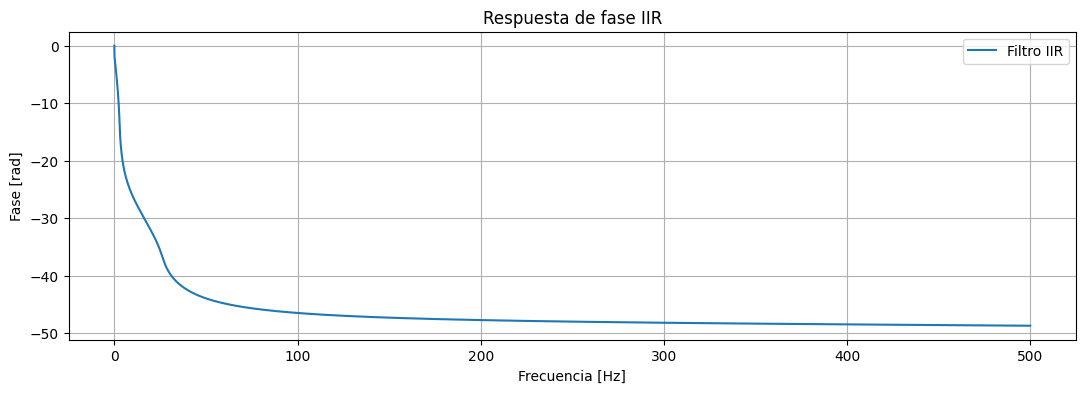

In [8]:
fig, ax = plt.subplots()

ax.plot(iir_W, angle_to_winding_number(np.angle(iir_H)), label="Filtro IIR")
ax.set_title('Respuesta de fase IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Fase [rad]')
ax.grid()
ax.legend()


plt.show()

### Respuesta de retardo de grupo FIR

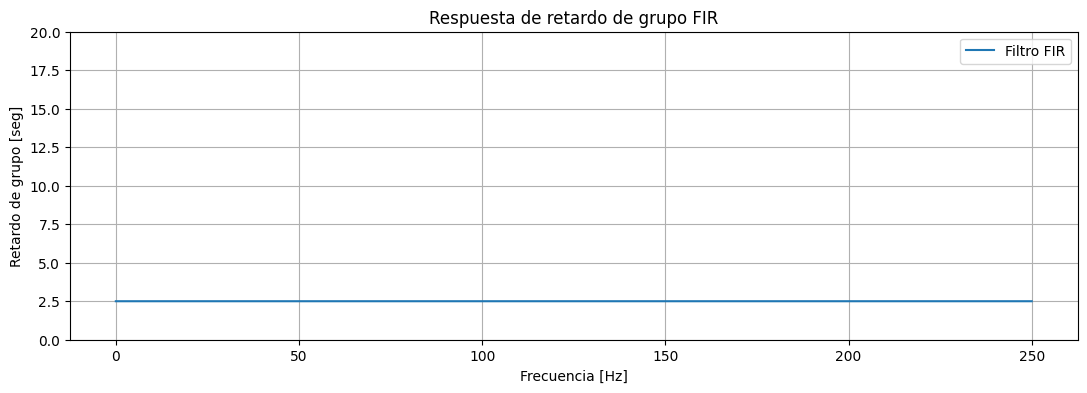

In [9]:
def get_delay_from_freq_response(W, H):
    new_freq = (W[1:] + W[:1])/2
    angles = angle_to_winding_number(np.angle(H))
    group_delay =  -np.diff(angles)/np.diff(W)
    return (new_freq, group_delay/(2*np.pi))

fig, ax = plt.subplots()

ax.plot(*get_delay_from_freq_response(fir_W, fir_H), label="Filtro FIR")
ax.set_title('Respuesta de retardo de grupo FIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Retardo de grupo [seg]')
ax.grid()
ax.set_ylim(0,20)
ax.legend()


fig.show()

Como es de esperar, el retardo de grupo es constante, pero se puede ver que su retardo de grupo es muy grande, alrededor de los 2.5 segundos. Eso para apliaciones de procesamiento en tiempo puede ser un problema.

### Respuesta de retardo de grupo IIR

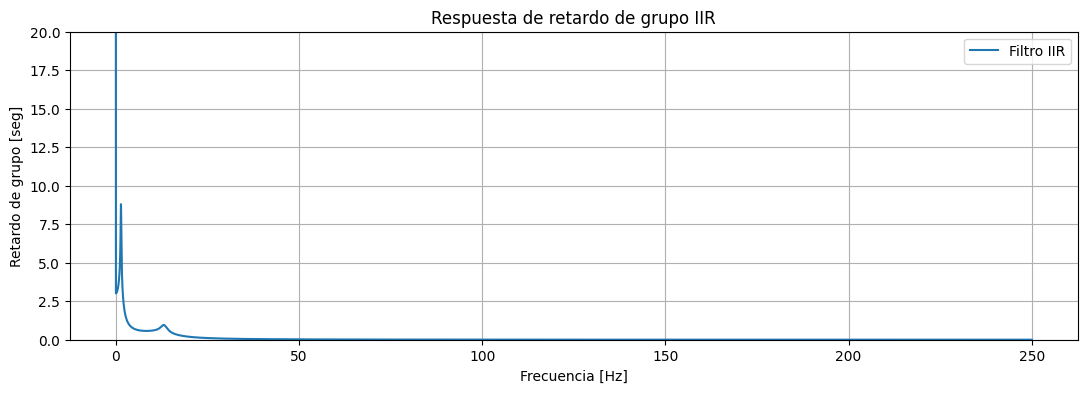

In [10]:
def get_delay_from_freq_response(W, H):
    new_freq = (W[1:] + W[:1])/2
    angles = angle_to_winding_number(np.angle(H))
    group_delay =  -np.diff(angles)/np.diff(W)
    return (new_freq, group_delay)

fig, ax = plt.subplots()

ax.plot(*get_delay_from_freq_response(iir_W, iir_H), label="Filtro IIR")
ax.set_title('Respuesta de retardo de grupo IIR')
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Retardo de grupo [seg]')
ax.grid()
ax.set_ylim(0,20)
ax.legend()


plt.show()

### Respuesta al impulso

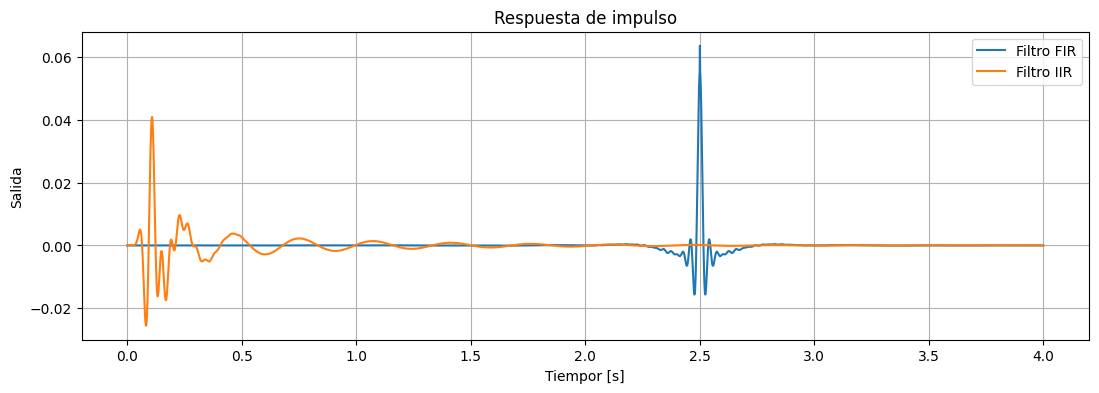

In [11]:
n_samples = 4000

impulse = np.concatenate(([1], np.zeros(n_samples-1)))

fir_response = sig.lfilter(taps_ls, [1], impulse)
iir_response = sig.sosfilt(iir_sos, impulse)


fig, ax = plt.subplots()

time_axis = np.linspace(0,n_samples/fs,n_samples)

ax.plot(time_axis, fir_response, label="Filtro FIR")
ax.plot(time_axis, iir_response, label="Filtro IIR")
ax.set_title('Respuesta de impulso')
ax.set_xlabel('Tiempor [s]')
ax.set_ylabel('Salida')
ax.grid()
ax.legend()


plt.show()

La respuesta al impulso del filtro FIR muestra como no se obtiene nada en la salida hasta los 2.5 segundos, este era el comportamiento esperado debido a su respuesta de grupoo constante en 2.5 segundos.
EL filtro IIR sin embargo, tiene una respuesta mas immediata, llegando a su maximo despues de los 100ms

# Parte 2 - Implementación y uso [Todavia completando]

Para demostrar el funcionamiento de los filtros, aplicaremos el filtro a una señal real de electrocardiograma. Se analizará el comportamiento del filtro en tres regiones de interes diferentes:

1) Ventana de 12 segundos donde la base de la señal no varia.
2) Ventana de 

## Aplicación del filtro FIR

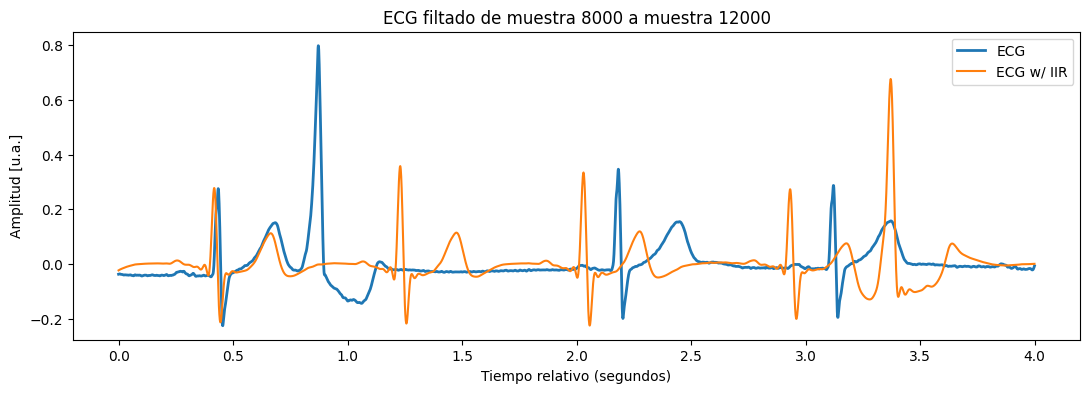

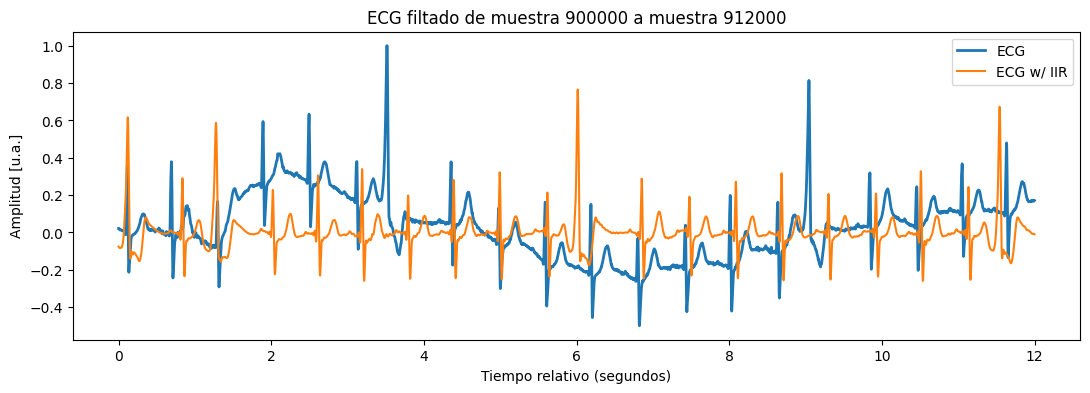

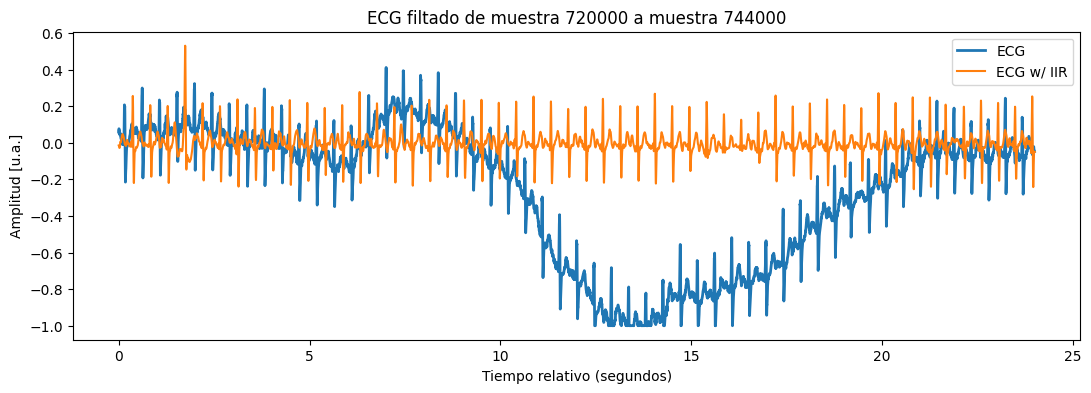

In [12]:
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()/max(ecg_one_lead)
cant_muestras = len(ecg_one_lead)
time_axis = np.linspace(0, cant_muestras/fs, cant_muestras)


ecg_fir = sig.lfilter(taps_ls, [1], ecg_one_lead)


regs_interes = ( 
        np.array([8e3, 12e3]), # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
    )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.plot(time_axis[:len(zoom_region)], ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(time_axis[:len(zoom_region)], ecg_fir[zoom_region], label='ECG w/ IIR')
    
    plt.title('ECG filtado de muestra ' + str(int(ii[0])) + ' a muestra ' + str(int(ii[1])) )
    plt.ylabel('Amplitud [u.a.]')
    plt.xlabel('Tiempo relativo (segundos)')

    plt.legend()
            
    plt.show()

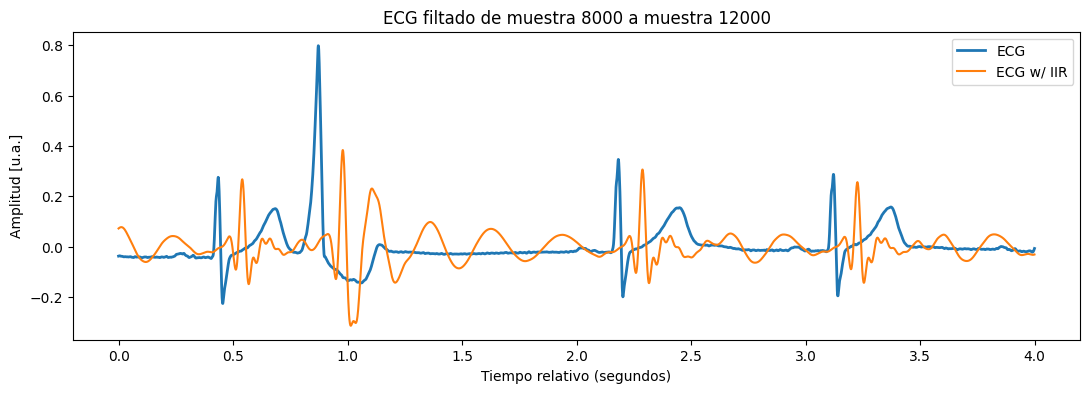

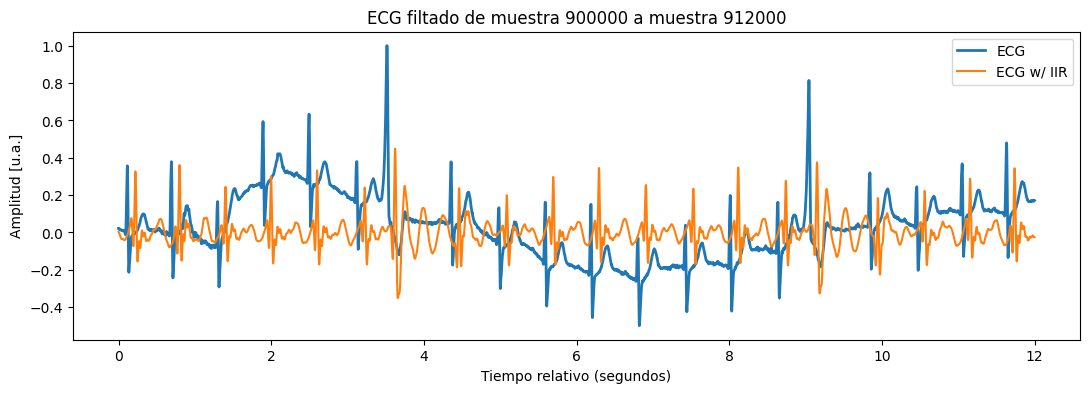

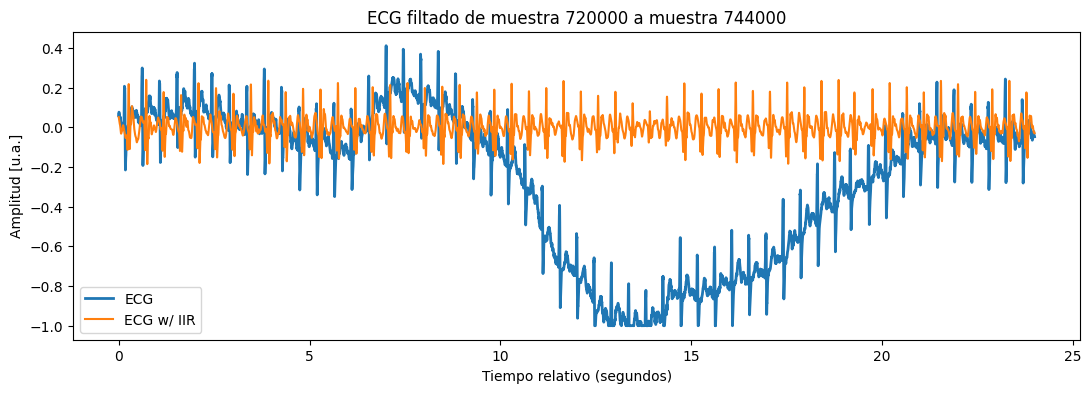

In [13]:
ecg_iir = sig.sosfilt(iir_sos, ecg_one_lead)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.plot(time_axis[:len(zoom_region)], ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(time_axis[:len(zoom_region)], ecg_iir[zoom_region], label='ECG w/ IIR')
    
    plt.title('ECG filtado de muestra ' + str(int(ii[0])) + ' a muestra ' + str(int(ii[1])) )
    plt.ylabel('Amplitud [u.a.]')
    plt.xlabel('Tiempo relativo (segundos)')

    plt.legend()
            
    plt.show()

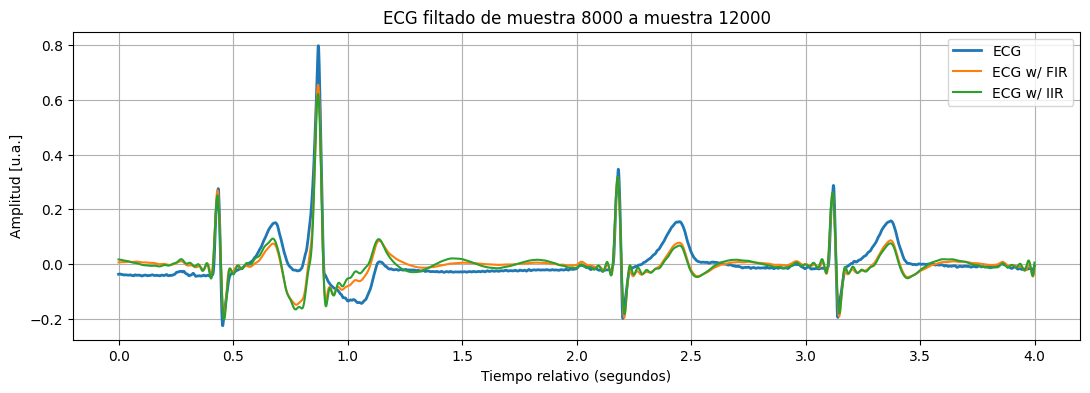

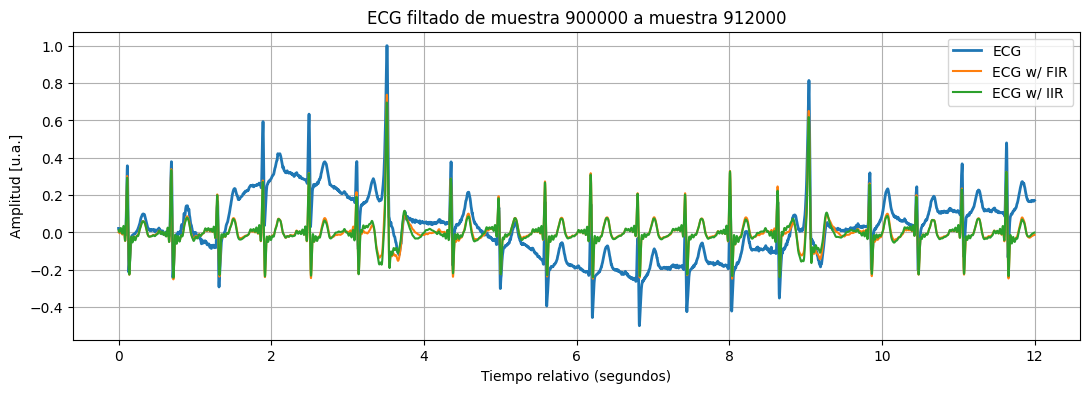

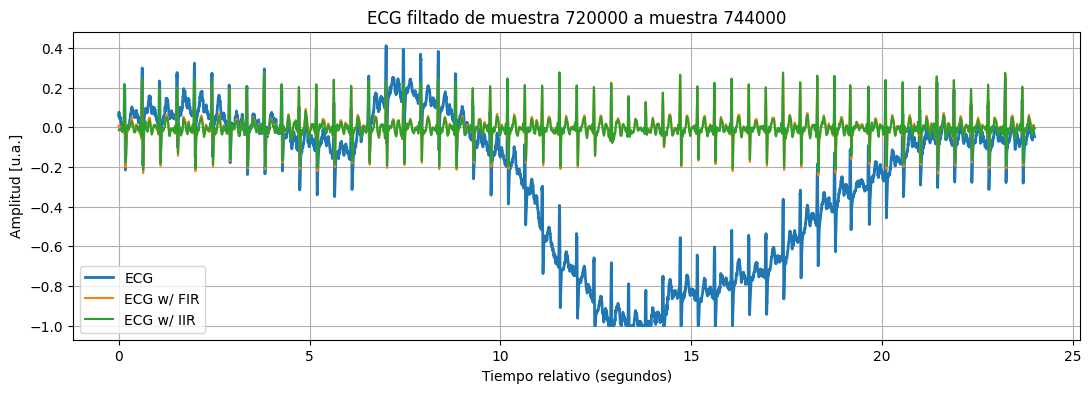

In [14]:
ecg_fir2 = sig.filtfilt(taps_ls, [1], ecg_one_lead)
ecg_iir2 = sig.sosfiltfilt(iir_sos, ecg_one_lead)

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.plot(time_axis[:len(zoom_region)], ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    plt.plot(time_axis[:len(zoom_region)], ecg_fir2[zoom_region], label='ECG w/ FIR')
    plt.plot(time_axis[:len(zoom_region)], ecg_iir2[zoom_region], label='ECG w/ IIR')

    plt.title('ECG filtado de muestra ' + str(int(ii[0])) + ' a muestra ' + str(int(ii[1])) )
    plt.ylabel('Amplitud [u.a.]')
    plt.xlabel('Tiempo relativo (segundos)')
    plt.grid()
    plt.legend()
            
    plt.show()